In [1]:
import json
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path

# Load task weights
with open('../utils/tasks_weights.json', 'r') as f:
    task_weights = json.load(f)

# get a list of all models with their paths
results_dir = Path('../results')

models = []
for company_dir in results_dir.iterdir():
    if company_dir.name == 'qdrant':  # Skip qdrant folder
        continue
    for model_dir in company_dir.iterdir():
        models.append(model_dir)

# Difference in MTEB Retrieval between baseline (float32) and different configs of quantization and PCA

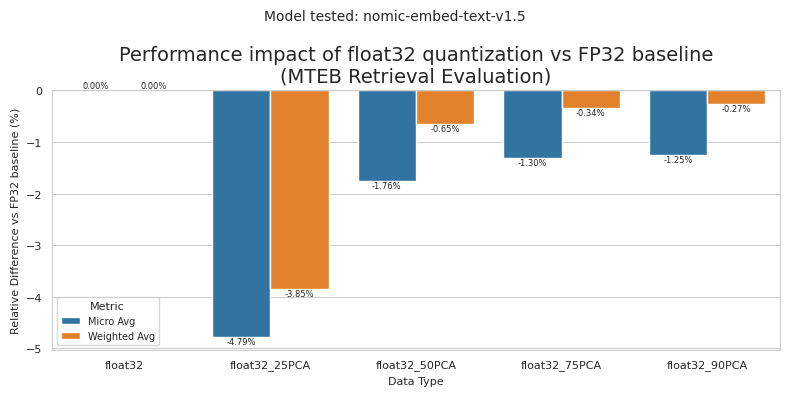

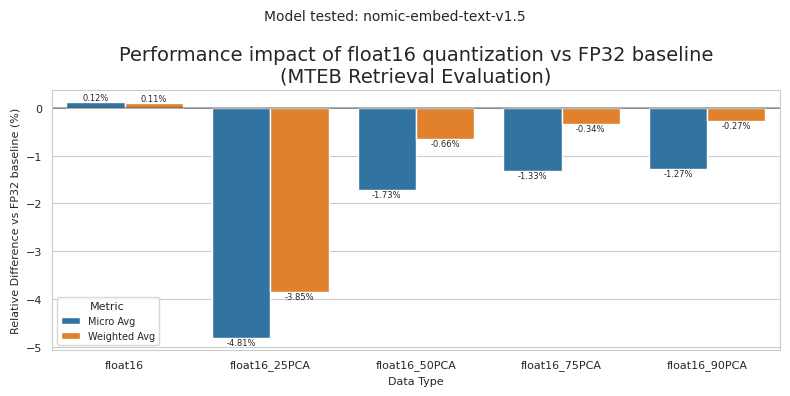

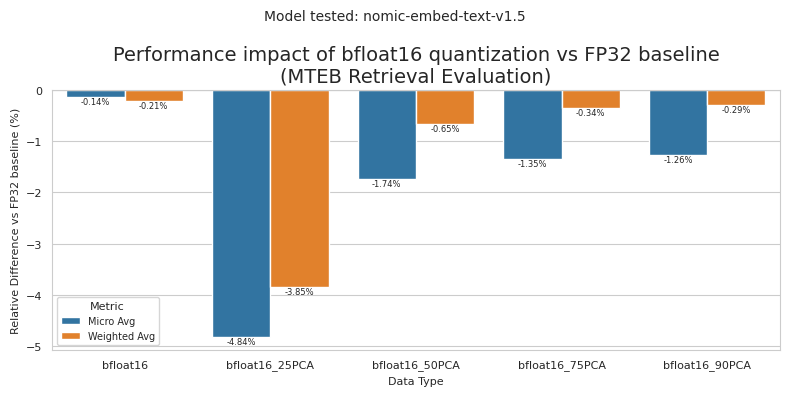

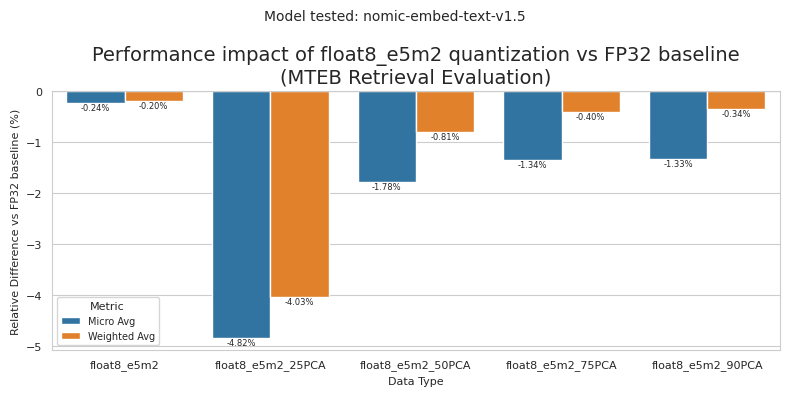

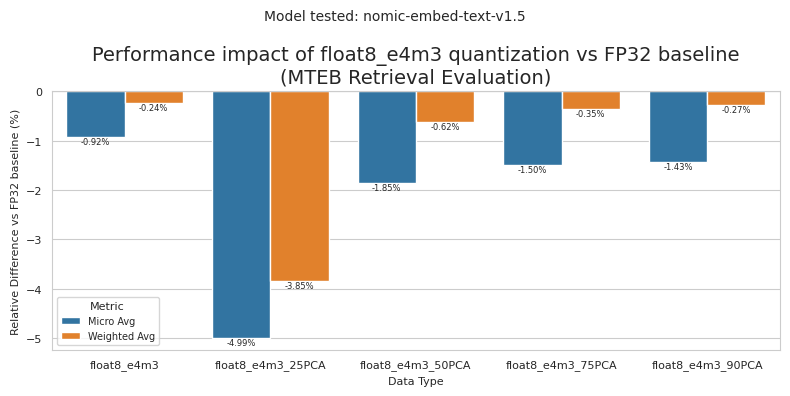

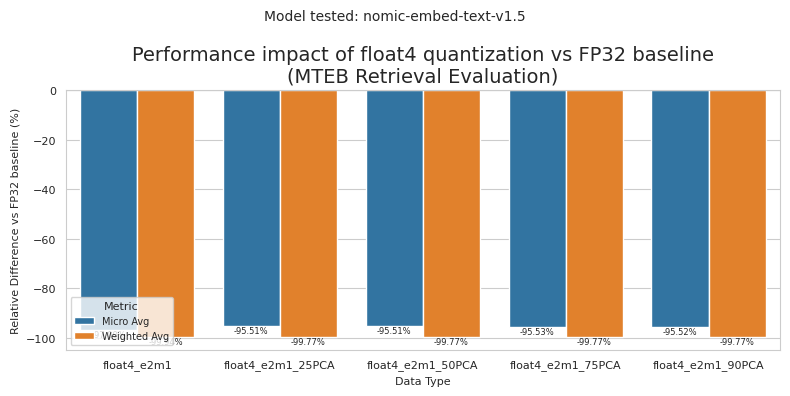

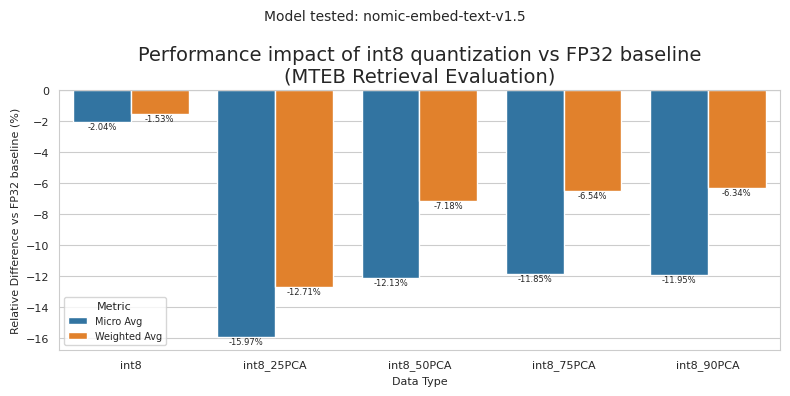

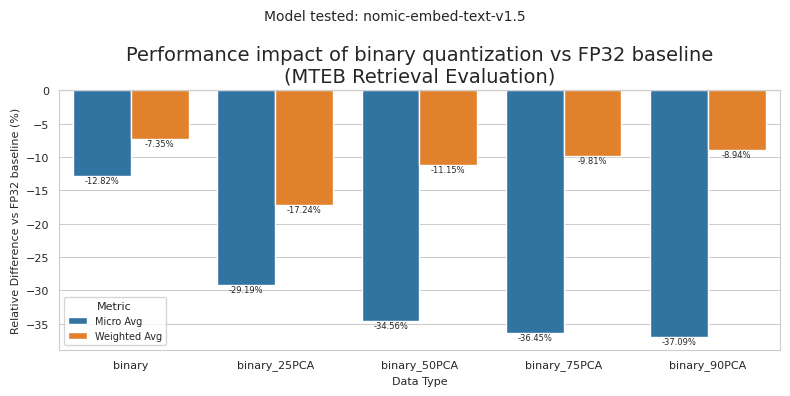

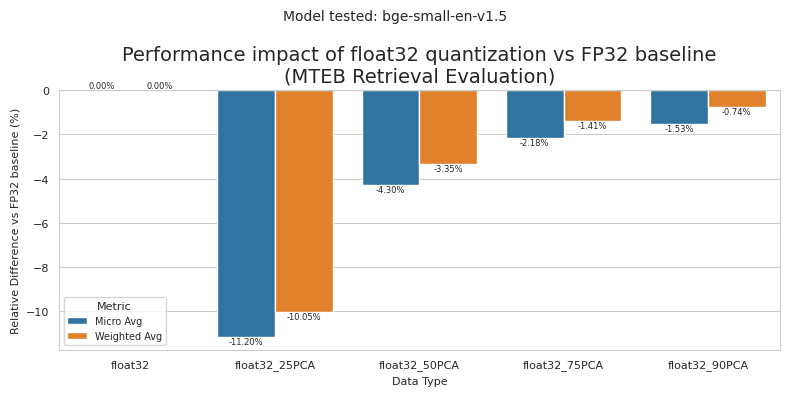

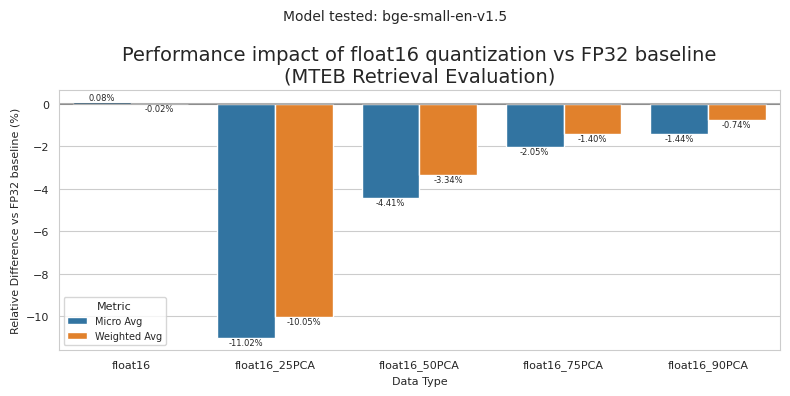

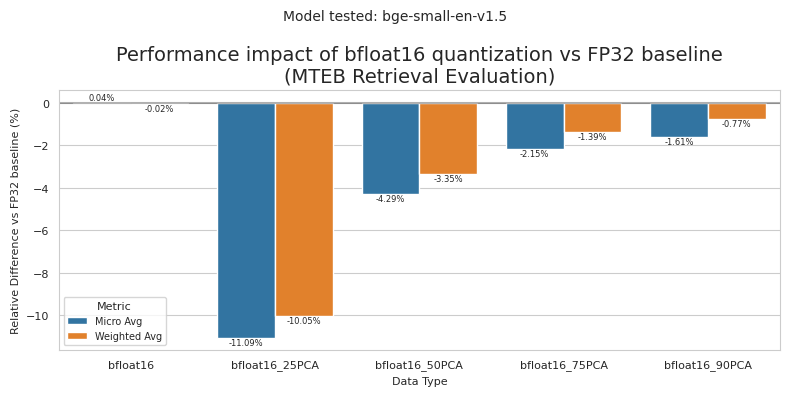

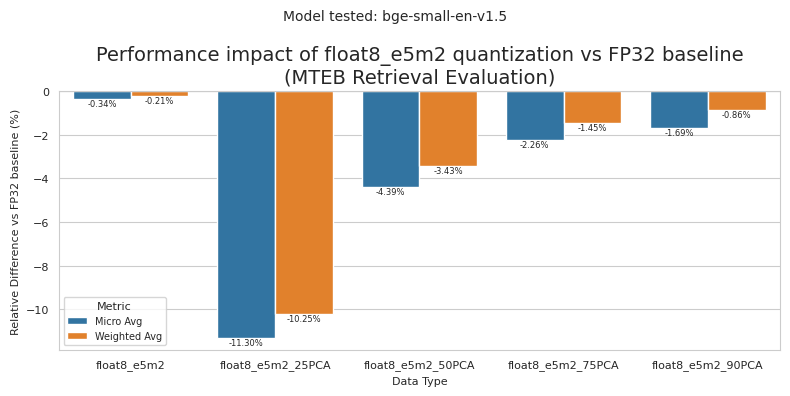

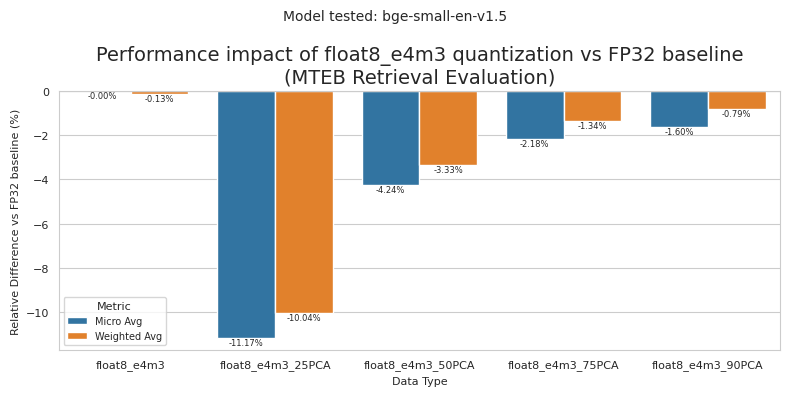

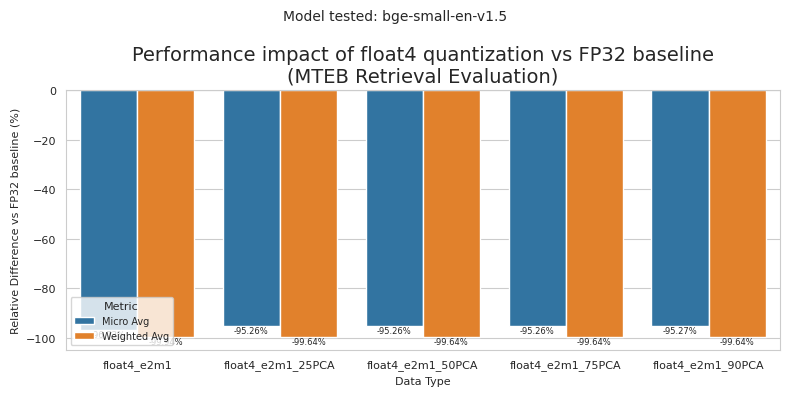

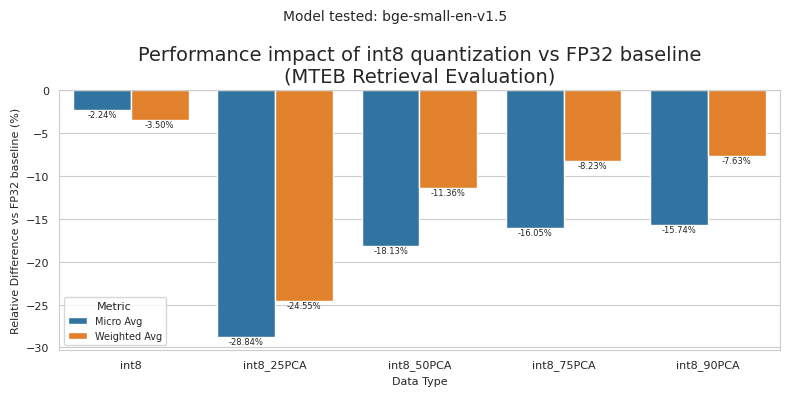

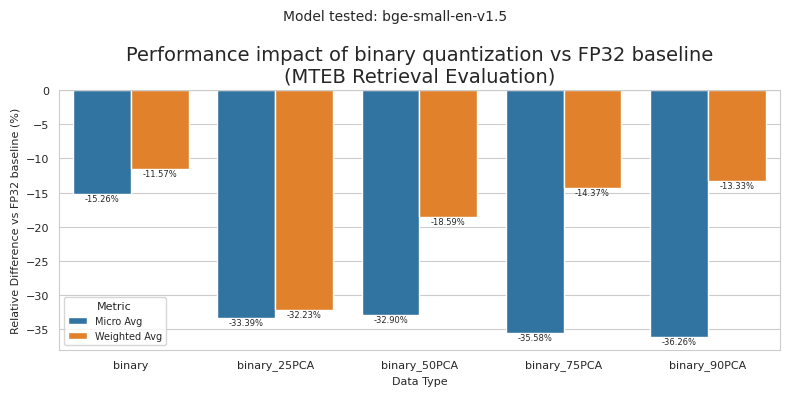

In [2]:
for model_path in models:

    # Load float32 baseline scores
    with open(model_path / 'results_float32.json', 'r') as f:
        float32_data = json.load(f)
        float32_scores = float32_data['scores']

    # Group files by base data type
    dtype_groups = {
        'float32': [],
        'float16': [],
        'bfloat16': [],
        'float8_e5m2': [],
        'float8_e4m3': [],
        'float4': [],
        'int8': [],
        'binary': []
    }

    for result_file in model_path.glob('results_*.json'):
        dtype = result_file.stem.replace('results_', '')
        # Check exact match for float16 and bfloat16 to avoid mixing them up
        if dtype == 'float16' or dtype.startswith('float16_'):
            dtype_groups['float16'].append(result_file)
        elif dtype == 'bfloat16' or dtype.startswith('bfloat16_'):
            dtype_groups['bfloat16'].append(result_file)
        else:
            for base_type in ['float32', 'float8_e5m2', 'float8_e4m3', 'float4', 'int8', 'binary']:
                if base_type in dtype:
                    dtype_groups[base_type].append(result_file)

    for base_type, files in dtype_groups.items():
        if not files:
            continue
            
        dtypes = []
        metrics = []
        relative_scores = []
        
        for result_file in files:
            dtype = result_file.stem.replace('results_', '')
            with open(result_file, 'r') as f:
                data = json.load(f)
                
            # Calculate micro average
            micro_avg = sum(data['scores'].values()) / len(data['scores'])
            micro_baseline = sum(float32_scores.values()) / len(float32_scores)
            micro_diff = ((micro_avg - micro_baseline) / micro_baseline) * 100
            
            # Calculate weighted average based on number of queries of the task
            weighted_sum = 0
            total_weight = 0
            weighted_baseline_sum = 0
            
            for task, score in data['scores'].items():
                weight = task_weights.get(task.split('-')[0], 0)  # Get base task name before -test
                weighted_sum += score * weight
                weighted_baseline_sum += float32_scores[task] * weight
                total_weight += weight
                
            weighted_avg = weighted_sum / total_weight if total_weight > 0 else 0
            weighted_baseline = weighted_baseline_sum / total_weight if total_weight > 0 else 0
            weighted_diff = ((weighted_avg - weighted_baseline) / weighted_baseline) * 100
            
            dtypes.extend([dtype] * 2)
            metrics.extend(['Micro Avg', 'Weighted Avg'])
            relative_scores.extend([micro_diff, weighted_diff])

        df = pd.DataFrame({
            'dtype': dtypes,
            'metric': metrics,
            'relative_diff': relative_scores
        })

        # Create individual plot
        plt.figure(figsize=(8, 4))
        sns.set_style("whitegrid")
        ax = plt.gca()
        sns.barplot(data=df, x='dtype', y='relative_diff', hue='metric', order=sorted(df['dtype'].unique()), ax=ax)
        
        plt.title(f'Performance impact of {base_type} quantization vs FP32 baseline\n(MTEB Retrieval Evaluation)', fontsize=14)
        plt.suptitle(f'Model tested: {model_path.name}', fontsize=10)

        plt.xlabel('Data Type', fontsize=8)
        plt.ylabel('Relative Difference vs FP32 baseline (%)', fontsize=8)
        plt.axhline(y=0, color='black', linestyle='-', alpha=0.3)
        
        # Set y-axis limits from -100 to 0
        # plt.ylim(-100, 0)
        
        # Add legend in bottom left corner
        plt.legend(title='Metric', loc='lower left', fontsize=7, title_fontsize=8)
        
        # Add value labels
        for container in ax.containers:
            ax.bar_label(container, fmt='%.2f%%', fontsize=6)

        # Make tick labels smaller
        plt.xticks(fontsize=8)
        plt.yticks(fontsize=8)

        plt.tight_layout()
        plt.show()

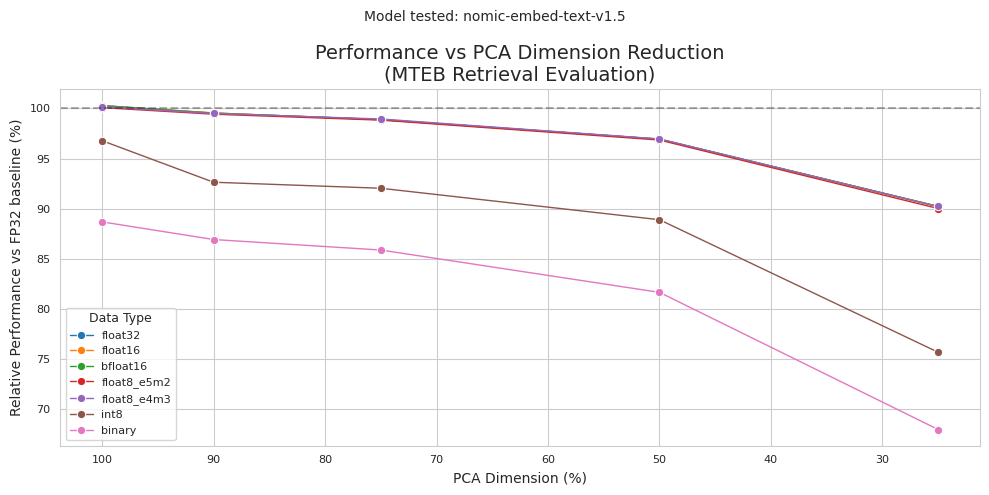

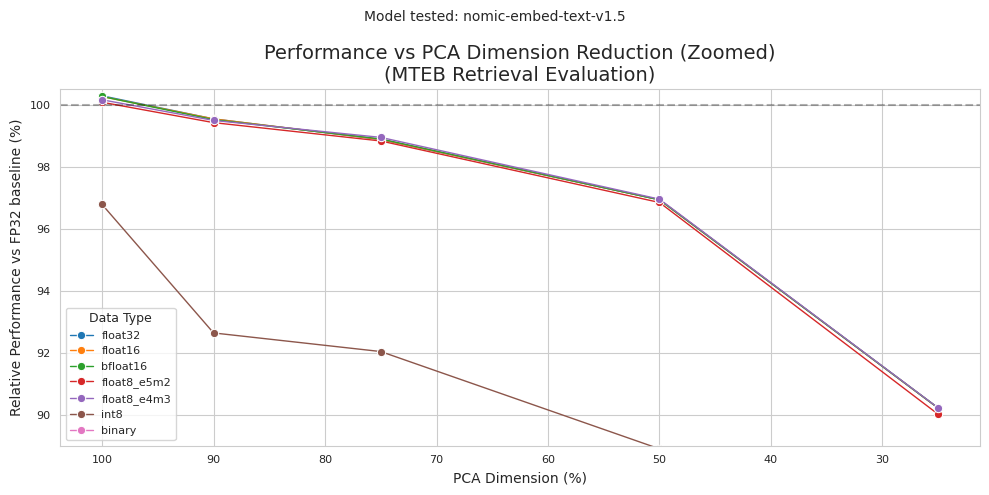

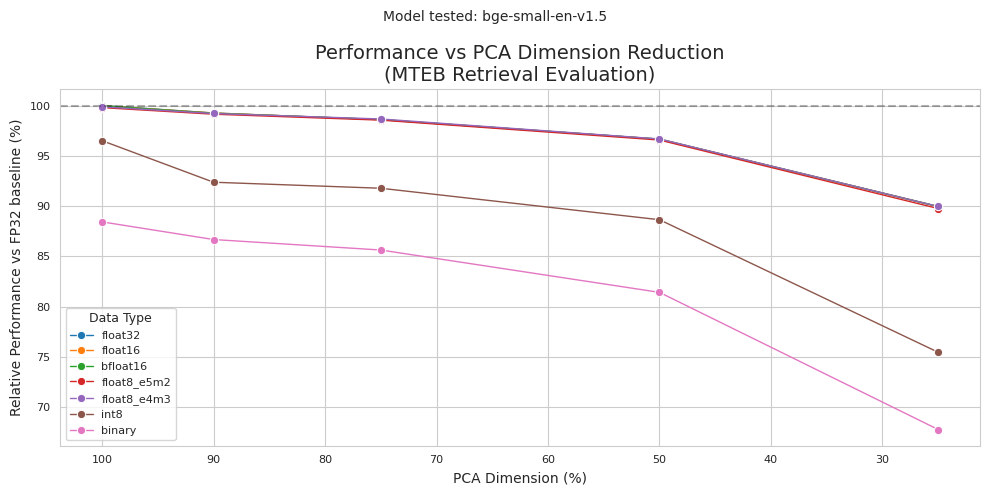

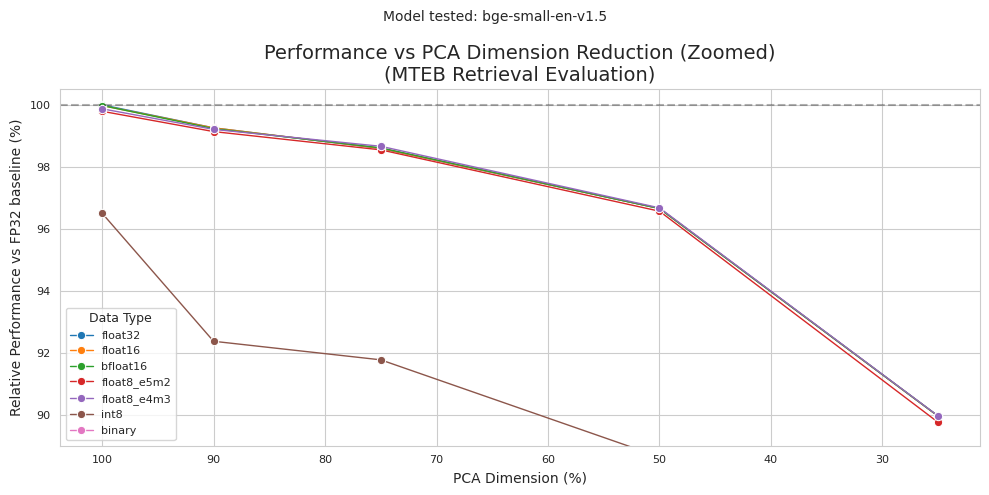

In [3]:
# Create PCA performance plot for each model
for model_path in models:
    # Load float32 baseline scores
    with open(model_path / 'results_float32.json', 'r') as f:
        float32_data = json.load(f)
        float32_scores = float32_data['scores']

    # Dictionary to store data for plotting
    plot_data = {
        'pca_percent': [],
        'relative_perf': [], 
        'dtype': []
    }

    # Process results for each base dtype
    for base_type, files in dtype_groups.items():
        if not files or base_type == 'float4':  # Skip float4
            continue
            
        # Sort files by PCA percentage
        def get_pca_percent(filename):
            if 'PCA' not in filename.stem:
                return 100  # No PCA = 100%
            return int(filename.stem.split('PCA')[0][-2:])  # Extract XX from XXPCA
            
        sorted_files = sorted(files, key=get_pca_percent)
        
        for result_file in sorted_files:
            pca_percent = get_pca_percent(result_file)
            dtype = result_file.stem.replace('results_', '')
            
            with open(result_file, 'r') as f:
                data = json.load(f)
                
            # Calculate weighted average based on number of queries of the task
            weighted_sum = 0
            total_weight = 0
            weighted_baseline_sum = 0
            
            for task, score in data['scores'].items():
                weight = task_weights.get(task.split('-')[0], 0)
                weighted_sum += score * weight
                weighted_baseline_sum += float32_scores[task] * weight
                total_weight += weight
                
            weighted_avg = weighted_sum / total_weight if total_weight > 0 else 0
            weighted_baseline = weighted_baseline_sum / total_weight if total_weight > 0 else 0
            
            # Convert to relative performance (100% = same as baseline)
            relative_perf = (weighted_avg / weighted_baseline) * 100
            
            plot_data['pca_percent'].append(pca_percent)
            plot_data['relative_perf'].append(relative_perf)
            plot_data['dtype'].append(base_type)

    # Create DataFrame
    df = pd.DataFrame(plot_data)

    # Create first plot - full range
    plt.figure(figsize=(10, 5))
    ax = plt.gca()
    sns.lineplot(data=df, x='pca_percent', y='relative_perf', hue='dtype', marker='o', ax=ax, linewidth=1)

    plt.title(f'Performance vs PCA Dimension Reduction\n(MTEB Retrieval Evaluation)', fontsize=14)
    plt.suptitle(f'Model tested: {model_path.name}', fontsize=10)

    plt.xlabel('PCA Dimension (%)', fontsize=10)
    plt.ylabel('Relative Performance vs FP32 baseline (%)', fontsize=10)
    plt.axhline(y=100, color='black', linestyle='--', alpha=0.3)

    # Reverse x-axis so 100% is on the left
    plt.gca().invert_xaxis()

    # Add legend
    plt.legend(title='Data Type', fontsize=8, title_fontsize=9)

    # Make tick labels readable
    plt.xticks(fontsize=8)
    plt.yticks(fontsize=8)

    plt.tight_layout()
    plt.show()

    # Create second plot - focused on top 15% performance range
    plt.figure(figsize=(10, 5))
    ax = plt.gca()
    sns.lineplot(data=df, x='pca_percent', y='relative_perf', hue='dtype', marker='o', ax=ax, linewidth=1)

    plt.title(f'Performance vs PCA Dimension Reduction (Zoomed)\n(MTEB Retrieval Evaluation)', fontsize=14)
    plt.suptitle(f'Model tested: {model_path.name}', fontsize=10)

    plt.xlabel('PCA Dimension (%)', fontsize=10)
    plt.ylabel('Relative Performance vs FP32 baseline (%)', fontsize=10)
    plt.axhline(y=100, color='black', linestyle='--', alpha=0.3)

    # Set y-axis limits to show only top 15% range
    min_perf = df['relative_perf'].min()
    plt.ylim(max(min_perf, 89), 100.5)  # Show 85-100% range or adjust if performance is lower

    # Reverse x-axis so 100% is on the left
    plt.gca().invert_xaxis()

    # Add legend
    plt.legend(title='Data Type', fontsize=8, title_fontsize=9)

    # Make tick labels readable
    plt.xticks(fontsize=8)
    plt.yticks(fontsize=8)

    plt.tight_layout()
    plt.show()


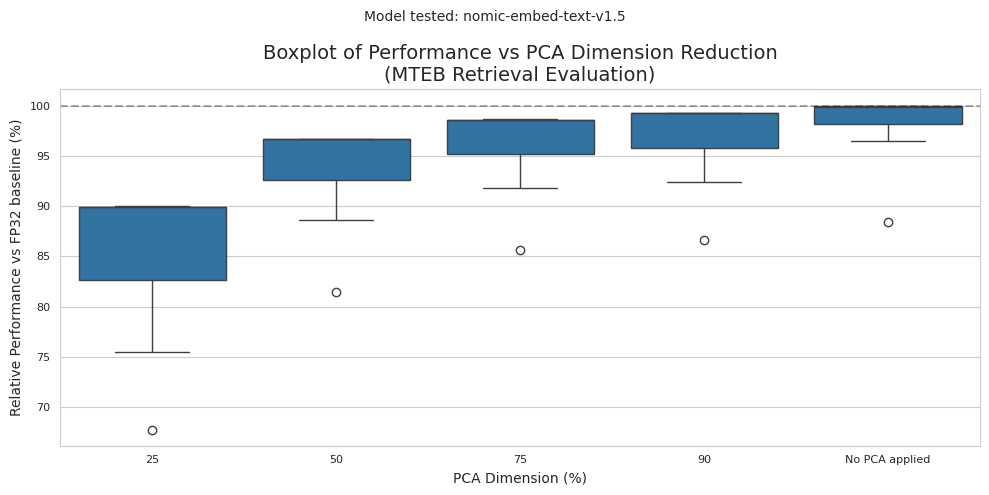

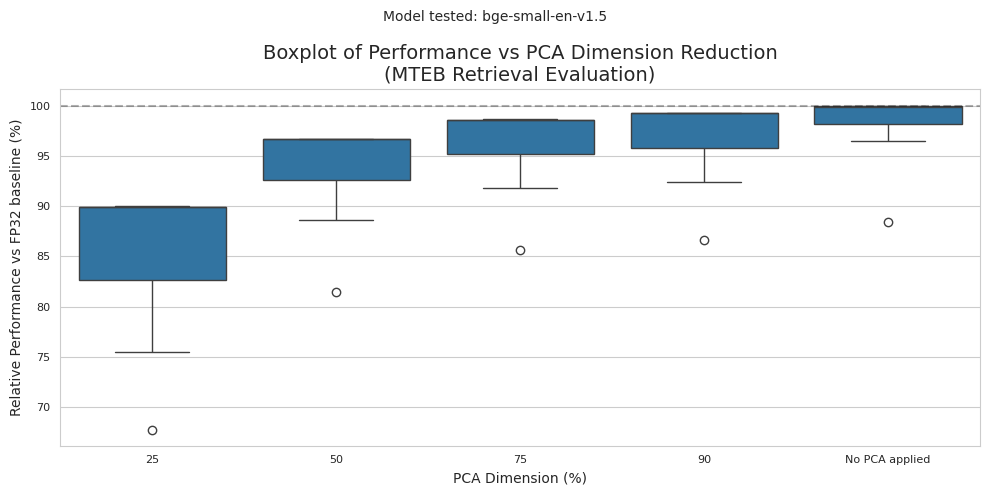

In [4]:
# Create boxplots for each model
for model_path in models:
    # Load float32 baseline scores for this model
    with open(model_path / 'results_float32.json', 'r') as f:
        float32_data = json.load(f)
        float32_scores = float32_data['scores']

    # Filter the DataFrame for the specified PCA percentages
    filtered_df = df[df['pca_percent'].isin([100, 90, 75, 50, 25])]

    # Replace 100 with "No PCA applied" for better readability 
    filtered_df['pca_percent'] = filtered_df['pca_percent'].replace(100, 'No PCA applied')

    plt.figure(figsize=(10, 5))
    ax = plt.gca()
    sns.color_palette()  # Use default seaborn palette

    # Create a boxplot combining all data types
    sns.boxplot(data=filtered_df, x='pca_percent', y='relative_perf', ax=ax)

    plt.title(f'Boxplot of Performance vs PCA Dimension Reduction\n(MTEB Retrieval Evaluation)', fontsize=14)
    plt.suptitle(f'Model tested: {model_path.name}', fontsize=10)

    plt.xlabel('PCA Dimension (%)', fontsize=10)
    plt.ylabel('Relative Performance vs FP32 baseline (%)', fontsize=10)
    plt.axhline(y=100, color='black', linestyle='--', alpha=0.3)

    # Make tick labels readable
    plt.xticks(fontsize=8)
    plt.yticks(fontsize=8)

    plt.tight_layout()
    plt.show()



High performers for float32 in nomic-embed-text-v1.5 (>150% baseline):
LEMBNarrativeQARetrieval-test: 152.5% (results_float32_25PCA.json)
LEMBQMSumRetrieval-test: 156.6% (results_float32_25PCA.json)
NarrativeQARetrieval-test: 152.5% (results_float32_25PCA.json)
SpartQA-test: 333.2% (results_float32_25PCA.json)
LEMBNarrativeQARetrieval-test: 167.2% (results_float32_75PCA.json)
LEMBPasskeyRetrieval-test_16384: 150.8% (results_float32_75PCA.json)
LEMBQMSumRetrieval-test: 158.0% (results_float32_75PCA.json)
NarrativeQARetrieval-test: 167.2% (results_float32_75PCA.json)
SpartQA-test: 332.9% (results_float32_75PCA.json)
WinoGrande-test: 172.2% (results_float32_75PCA.json)
LEMBNarrativeQARetrieval-test: 167.3% (results_float32_90PCA.json)
LEMBQMSumRetrieval-test: 158.2% (results_float32_90PCA.json)
NarrativeQARetrieval-test: 167.2% (results_float32_90PCA.json)
SpartQA-test: 332.8% (results_float32_90PCA.json)
WinoGrande-test: 172.5% (results_float32_90PCA.json)
LEMBNarrativeQARetrieval-test:

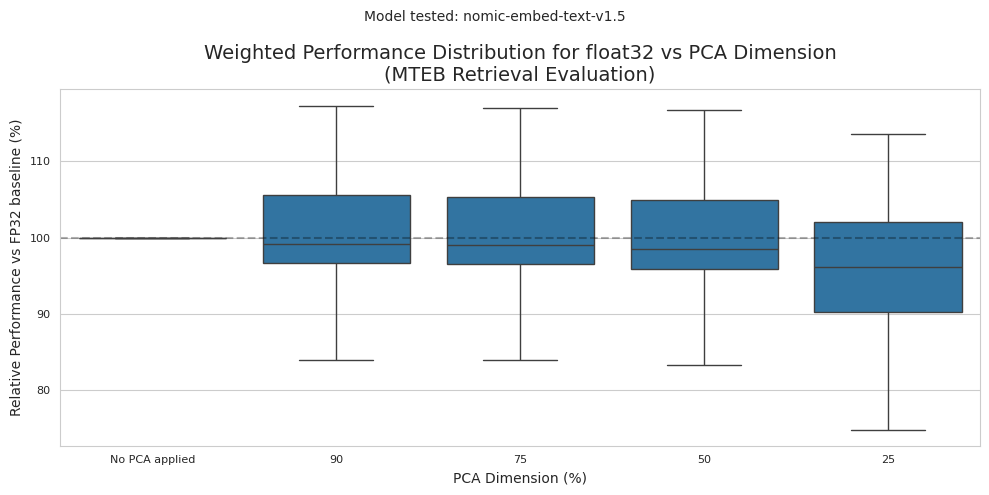


High performers for float16 in nomic-embed-text-v1.5 (>150% baseline):
LEMBNarrativeQARetrieval-test: 165.3% (results_float16_50PCA.json)
LEMBPasskeyRetrieval-test_16384: 150.5% (results_float16_50PCA.json)
LEMBQMSumRetrieval-test: 158.0% (results_float16_50PCA.json)
NarrativeQARetrieval-test: 165.2% (results_float16_50PCA.json)
SpartQA-test: 332.7% (results_float16_50PCA.json)
WinoGrande-test: 166.0% (results_float16_50PCA.json)
LEMBNarrativeQARetrieval-test: 167.2% (results_float16_90PCA.json)
LEMBPasskeyRetrieval-test_16384: 150.5% (results_float16_90PCA.json)
LEMBQMSumRetrieval-test: 158.4% (results_float16_90PCA.json)
NarrativeQARetrieval-test: 167.2% (results_float16_90PCA.json)
SpartQA-test: 332.6% (results_float16_90PCA.json)
WinoGrande-test: 172.4% (results_float16_90PCA.json)
LEMBNarrativeQARetrieval-test: 167.2% (results_float16_75PCA.json)
LEMBPasskeyRetrieval-test_16384: 151.7% (results_float16_75PCA.json)
LEMBQMSumRetrieval-test: 158.0% (results_float16_75PCA.json)
Narra

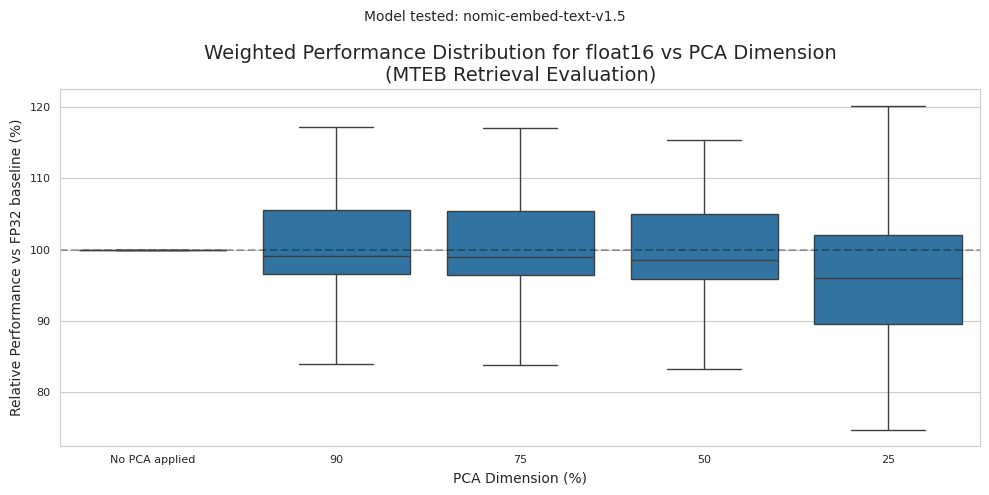


High performers for bfloat16 in nomic-embed-text-v1.5 (>150% baseline):
LEMBNarrativeQARetrieval-test: 152.4% (results_bfloat16_25PCA.json)
LEMBQMSumRetrieval-test: 156.7% (results_bfloat16_25PCA.json)
NarrativeQARetrieval-test: 152.4% (results_bfloat16_25PCA.json)
SpartQA-test: 333.5% (results_bfloat16_25PCA.json)
LEMBNarrativeQARetrieval-test: 167.4% (results_bfloat16_90PCA.json)
LEMBQMSumRetrieval-test: 157.8% (results_bfloat16_90PCA.json)
NarrativeQARetrieval-test: 167.4% (results_bfloat16_90PCA.json)
SpartQA-test: 333.2% (results_bfloat16_90PCA.json)
WinoGrande-test: 173.1% (results_bfloat16_90PCA.json)
LEMBNarrativeQARetrieval-test: 167.1% (results_bfloat16_75PCA.json)
LEMBQMSumRetrieval-test: 157.8% (results_bfloat16_75PCA.json)
NarrativeQARetrieval-test: 167.1% (results_bfloat16_75PCA.json)
SpartQA-test: 333.1% (results_bfloat16_75PCA.json)
WinoGrande-test: 172.3% (results_bfloat16_75PCA.json)
LEMBNarrativeQARetrieval-test: 165.2% (results_bfloat16_50PCA.json)
LEMBQMSumRetriev

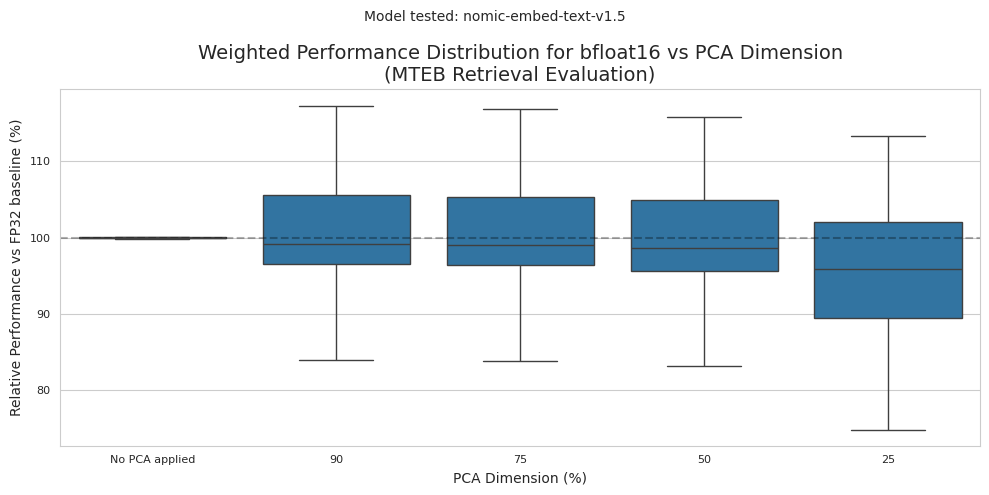


High performers for float8_e5m2 in nomic-embed-text-v1.5 (>150% baseline):
LEMBNarrativeQARetrieval-test: 158.0% (results_float8_e5m2_75PCA.json)
LEMBNeedleRetrieval-test_4096: 161.5% (results_float8_e5m2_75PCA.json)
LEMBPasskeyRetrieval-test_16384: 159.5% (results_float8_e5m2_75PCA.json)
LEMBQMSumRetrieval-test: 157.9% (results_float8_e5m2_75PCA.json)
NarrativeQARetrieval-test: 157.9% (results_float8_e5m2_75PCA.json)
SpartQA-test: 332.0% (results_float8_e5m2_75PCA.json)
WinoGrande-test: 166.4% (results_float8_e5m2_75PCA.json)
LEMBNeedleRetrieval-test_4096: 165.6% (results_float8_e5m2_25PCA.json)
LEMBPasskeyRetrieval-test_16384: 161.4% (results_float8_e5m2_25PCA.json)
LEMBQMSumRetrieval-test: 155.3% (results_float8_e5m2_25PCA.json)
SpartQA-test: 331.9% (results_float8_e5m2_25PCA.json)
LEMBNarrativeQARetrieval-test: 156.3% (results_float8_e5m2_50PCA.json)
LEMBNeedleRetrieval-test_4096: 161.5% (results_float8_e5m2_50PCA.json)
LEMBPasskeyRetrieval-test_16384: 159.8% (results_float8_e5m2_

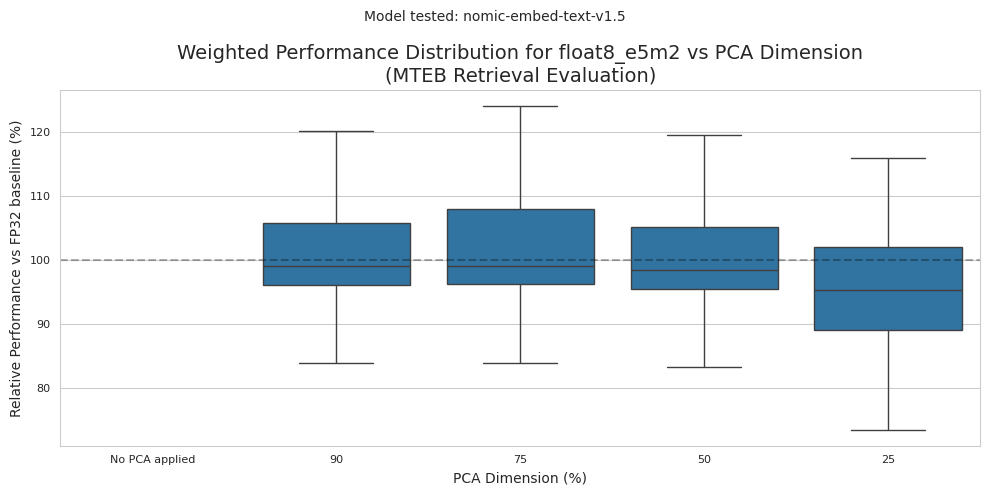


High performers for float8_e4m3 in nomic-embed-text-v1.5 (>150% baseline):
LEMBNarrativeQARetrieval-test: 151.9% (results_float8_e4m3_25PCA.json)
LEMBNeedleRetrieval-test_4096: 172.8% (results_float8_e4m3_25PCA.json)
LEMBQMSumRetrieval-test: 157.7% (results_float8_e4m3_25PCA.json)
NarrativeQARetrieval-test: 151.9% (results_float8_e4m3_25PCA.json)
SpartQA-test: 334.5% (results_float8_e4m3_25PCA.json)
LEMBNarrativeQARetrieval-test: 166.5% (results_float8_e4m3_75PCA.json)
LEMBNeedleRetrieval-test_4096: 172.8% (results_float8_e4m3_75PCA.json)
LEMBPasskeyRetrieval-test_16384: 187.2% (results_float8_e4m3_75PCA.json)
LEMBQMSumRetrieval-test: 159.8% (results_float8_e4m3_75PCA.json)
NarrativeQARetrieval-test: 166.5% (results_float8_e4m3_75PCA.json)
SpartQA-test: 333.9% (results_float8_e4m3_75PCA.json)
WinoGrande-test: 168.7% (results_float8_e4m3_75PCA.json)
LEMBNarrativeQARetrieval-test: 166.6% (results_float8_e4m3_90PCA.json)
LEMBNeedleRetrieval-test_4096: 172.8% (results_float8_e4m3_90PCA.js

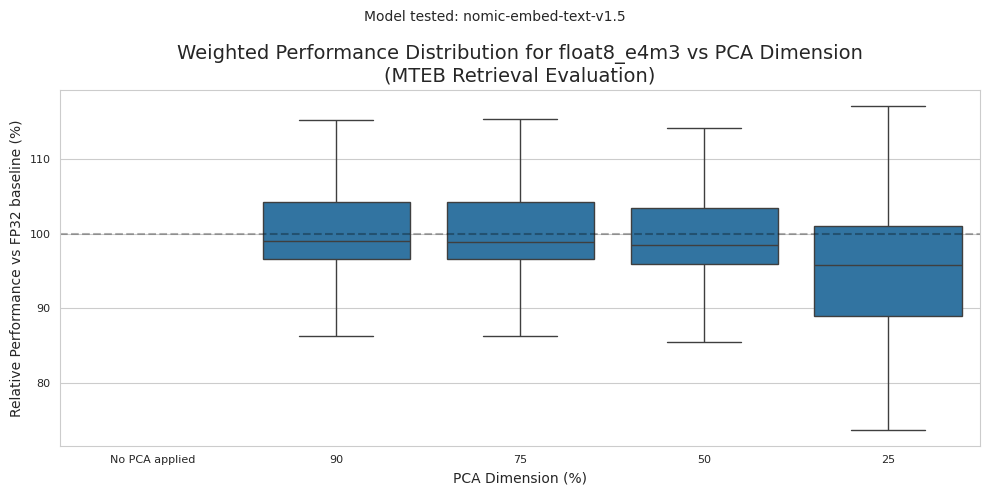

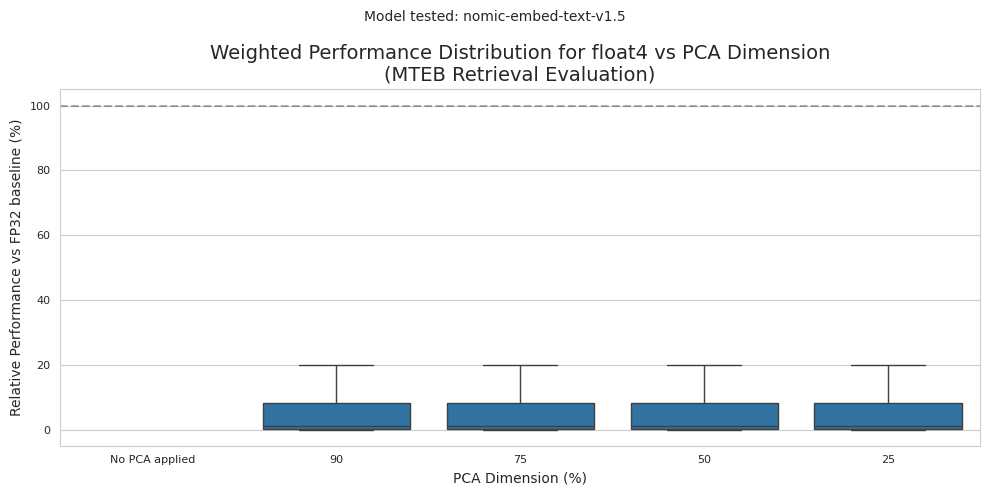


High performers for int8 in nomic-embed-text-v1.5 (>150% baseline):
LEMBPasskeyRetrieval-test_1024: 224.3% (results_int8_25PCA.json)
LEMBPasskeyRetrieval-test_2048: 206.2% (results_int8_25PCA.json)
LEMBPasskeyRetrieval-test_16384: 326.1% (results_int8_25PCA.json)
LEMBPasskeyRetrieval-test_1024: 224.3% (results_int8_50PCA.json)
LEMBPasskeyRetrieval-test_2048: 197.8% (results_int8_50PCA.json)
LEMBPasskeyRetrieval-test_16384: 327.6% (results_int8_50PCA.json)
LEMBPasskeyRetrieval-test_1024: 224.3% (results_int8_75PCA.json)
LEMBPasskeyRetrieval-test_2048: 200.0% (results_int8_75PCA.json)
LEMBPasskeyRetrieval-test_16384: 319.7% (results_int8_75PCA.json)
LEMBPasskeyRetrieval-test_1024: 224.3% (results_int8_90PCA.json)
LEMBPasskeyRetrieval-test_2048: 200.0% (results_int8_90PCA.json)
LEMBPasskeyRetrieval-test_16384: 319.7% (results_int8_90PCA.json)


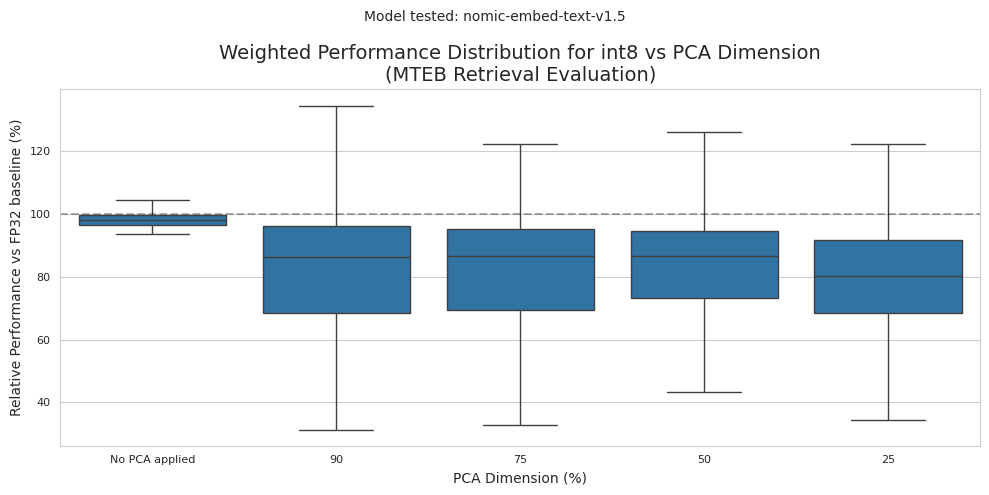


High performers for binary in nomic-embed-text-v1.5 (>150% baseline):
LEMBPasskeyRetrieval-test_16384: 192.7% (results_binary_75PCA.json)
SIQA-test: 232.3% (results_binary_75PCA.json)
WinoGrande-test: 172.9% (results_binary_75PCA.json)
LEMBPasskeyRetrieval-test_16384: 198.6% (results_binary.json)
LEMBPasskeyRetrieval-test_32768: 153.1% (results_binary.json)
LEMBPasskeyRetrieval-test_16384: 236.9% (results_binary_50PCA.json)
SIQA-test: 200.1% (results_binary_50PCA.json)
WinoGrande-test: 175.5% (results_binary_50PCA.json)
LEMBPasskeyRetrieval-test_16384: 180.2% (results_binary_90PCA.json)
SIQA-test: 251.9% (results_binary_90PCA.json)
WinoGrande-test: 173.3% (results_binary_90PCA.json)
LEMBPasskeyRetrieval-test_16384: 183.4% (results_binary_25PCA.json)


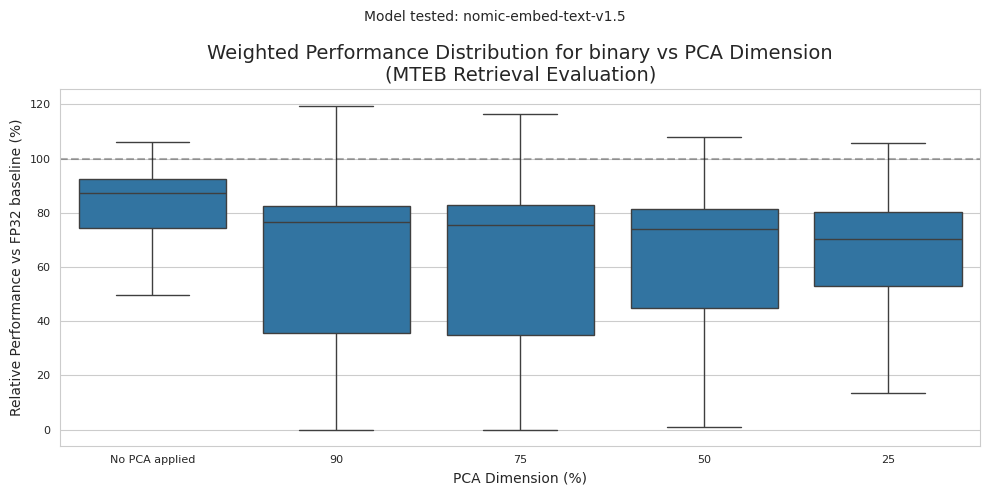


High performers for float32 in bge-small-en-v1.5 (>150% baseline):
SpartQA-test: 408.9% (results_float32_25PCA.json)
SpartQA-test: 410.2% (results_float32_75PCA.json)
LEMBNeedleRetrieval-test_16384: 166.9% (results_float32_90PCA.json)
SpartQA-test: 410.1% (results_float32_90PCA.json)
SpartQA-test: 410.5% (results_float32_50PCA.json)


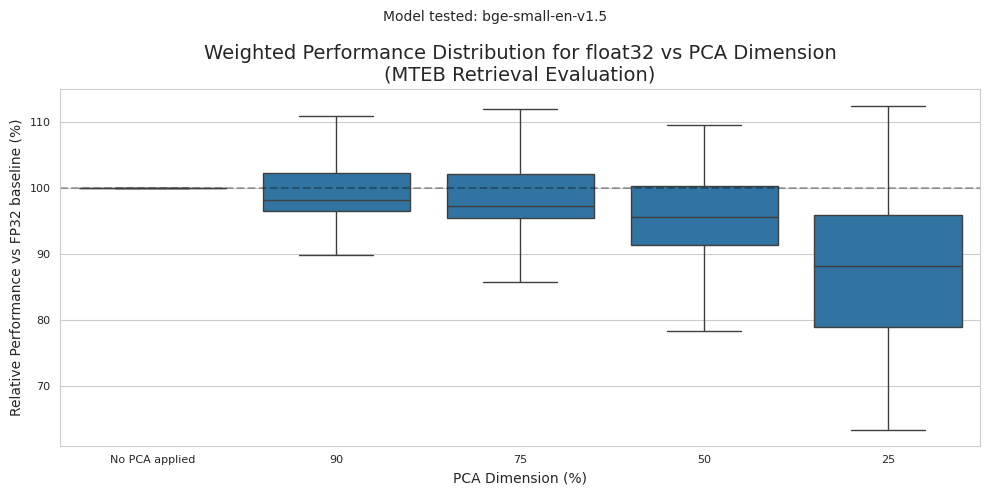


High performers for float16 in bge-small-en-v1.5 (>150% baseline):
SpartQA-test: 410.3% (results_float16_50PCA.json)
LEMBNeedleRetrieval-test_16384: 173.5% (results_float16_90PCA.json)
SpartQA-test: 410.0% (results_float16_90PCA.json)
SpartQA-test: 410.3% (results_float16_75PCA.json)
SpartQA-test: 409.0% (results_float16_25PCA.json)


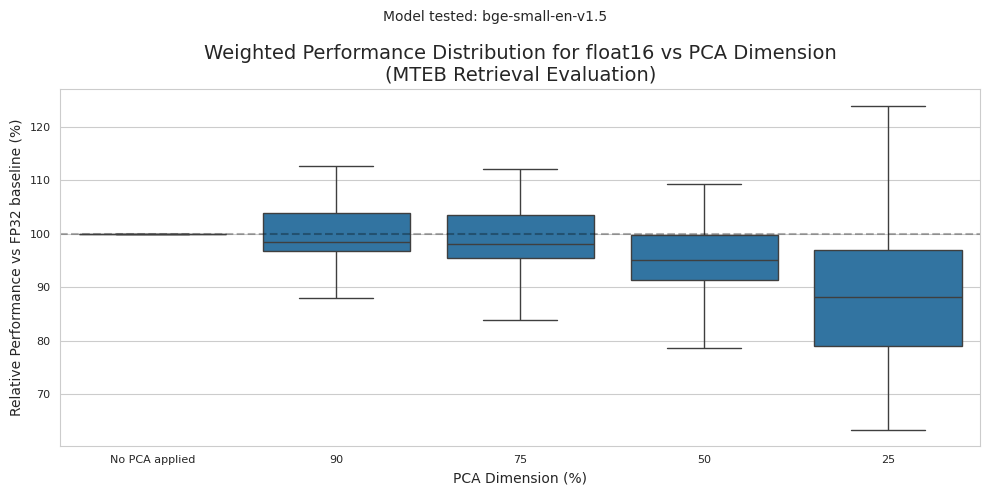


High performers for bfloat16 in bge-small-en-v1.5 (>150% baseline):
SpartQA-test: 409.1% (results_bfloat16_25PCA.json)
SpartQA-test: 409.4% (results_bfloat16_90PCA.json)
SpartQA-test: 409.7% (results_bfloat16_75PCA.json)
LEMBNeedleRetrieval-test_16384: 154.4% (results_bfloat16.json)
SpartQA-test: 410.3% (results_bfloat16_50PCA.json)


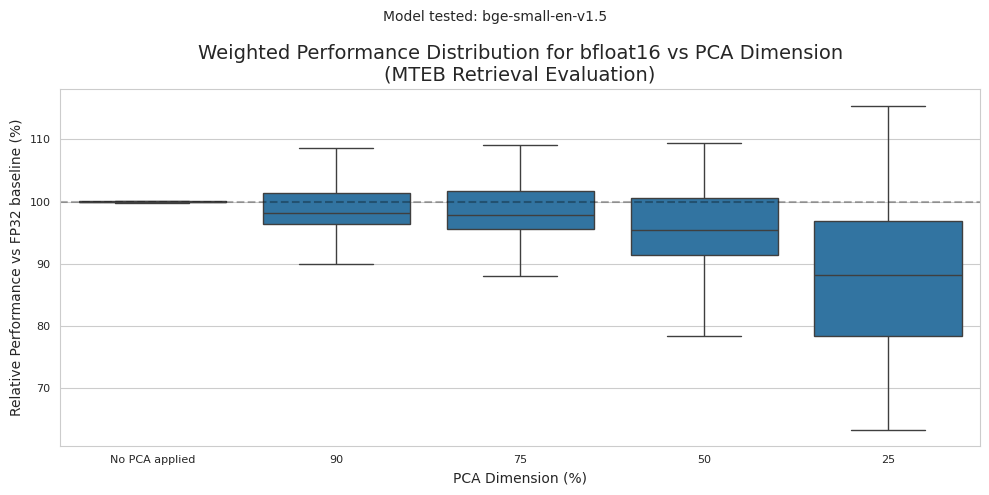


High performers for float8_e5m2 in bge-small-en-v1.5 (>150% baseline):
AILAStatutes-test: 151.0% (results_float8_e5m2_75PCA.json)
SpartQA-test: 405.0% (results_float8_e5m2_75PCA.json)
AILAStatutes-test: 151.8% (results_float8_e5m2_25PCA.json)
SpartQA-test: 405.5% (results_float8_e5m2_25PCA.json)
AILAStatutes-test: 151.0% (results_float8_e5m2_50PCA.json)
SpartQA-test: 405.5% (results_float8_e5m2_50PCA.json)
AILAStatutes-test: 151.0% (results_float8_e5m2_90PCA.json)
SpartQA-test: 405.3% (results_float8_e5m2_90PCA.json)


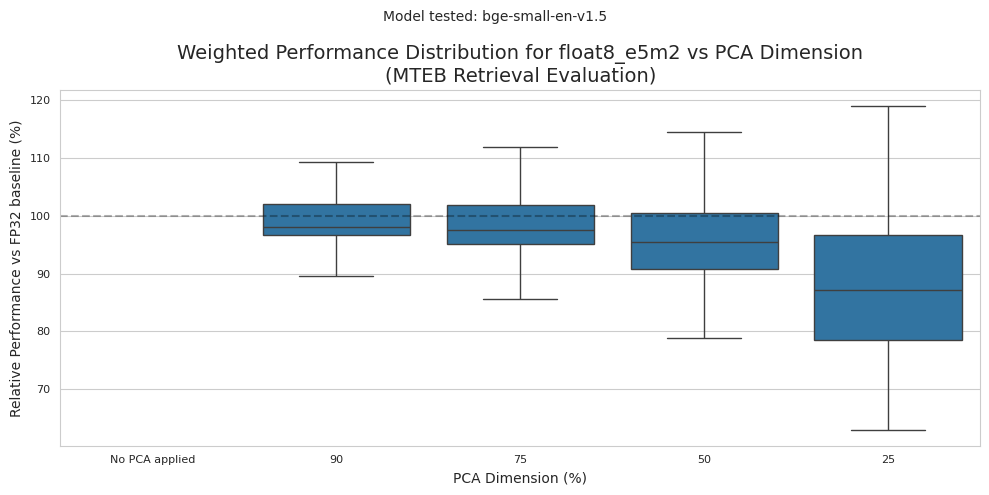


High performers for float8_e4m3 in bge-small-en-v1.5 (>150% baseline):
SpartQA-test: 422.2% (results_float8_e4m3_25PCA.json)
SpartQA-test: 421.5% (results_float8_e4m3_75PCA.json)
SpartQA-test: 421.5% (results_float8_e4m3_90PCA.json)
SpartQA-test: 421.8% (results_float8_e4m3_50PCA.json)


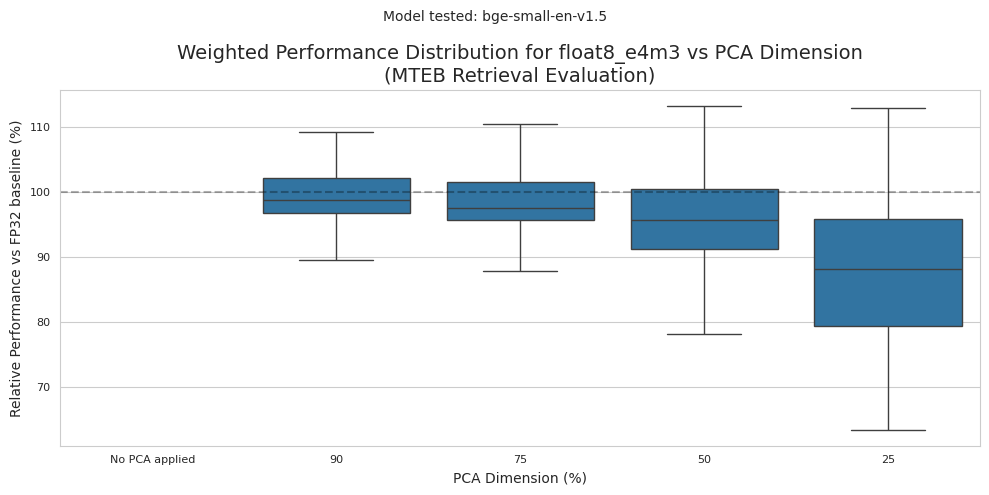


High performers for float4 in bge-small-en-v1.5 (>150% baseline):
LEMBNeedleRetrieval-test_16384: 157.2% (results_float4_e2m1_25PCA.json)
LEMBNeedleRetrieval-test_16384: 157.2% (results_float4_e2m1_90PCA.json)
LEMBNeedleRetrieval-test_16384: 157.2% (results_float4_e2m1_75PCA.json)
LEMBNeedleRetrieval-test_16384: 157.2% (results_float4_e2m1_50PCA.json)


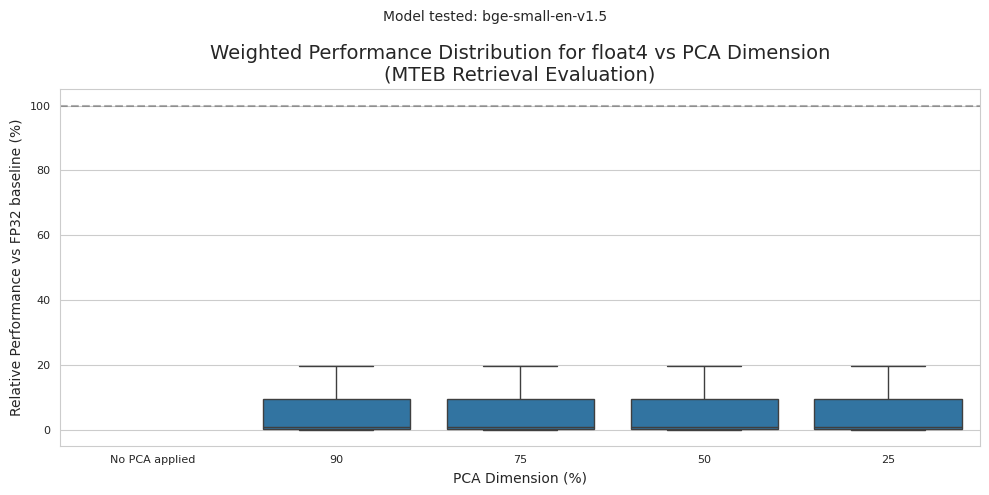


High performers for int8 in bge-small-en-v1.5 (>150% baseline):
LEMBNeedleRetrieval-test_32768: 151.4% (results_int8_25PCA.json)
LEMBPasskeyRetrieval-test_8192: 157.9% (results_int8_25PCA.json)
LEMBPasskeyRetrieval-test_16384: 181.9% (results_int8_25PCA.json)
LEMBPasskeyRetrieval-test_32768: 172.2% (results_int8_25PCA.json)
LEMBPasskeyRetrieval-test_8192: 185.4% (results_int8_50PCA.json)
LEMBNeedleRetrieval-test_16384: 191.6% (results_int8.json)
LEMBPasskeyRetrieval-test_8192: 163.2% (results_int8_75PCA.json)
LEMBNeedleRetrieval-test_16384: 250.0% (results_int8_90PCA.json)
LEMBPasskeyRetrieval-test_16384: 173.9% (results_int8_90PCA.json)


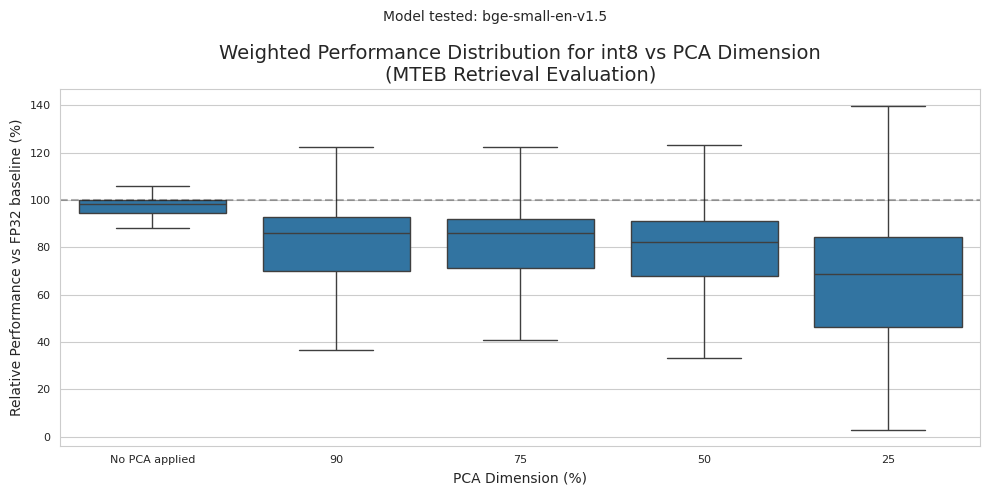


High performers for binary in bge-small-en-v1.5 (>150% baseline):
SIQA-test: 308.3% (results_binary_75PCA.json)
WinoGrande-test: 254.4% (results_binary_75PCA.json)
LEMBNeedleRetrieval-test_16384: 217.0% (results_binary_50PCA.json)
SIQA-test: 212.3% (results_binary_50PCA.json)
WinoGrande-test: 189.9% (results_binary_50PCA.json)
Quail-test: 160.2% (results_binary_90PCA.json)
SIQA-test: 345.3% (results_binary_90PCA.json)
WinoGrande-test: 277.4% (results_binary_90PCA.json)
LEMBNeedleRetrieval-test_16384: 168.0% (results_binary_25PCA.json)
LEMBPasskeyRetrieval-test_2048: 159.2% (results_binary_25PCA.json)


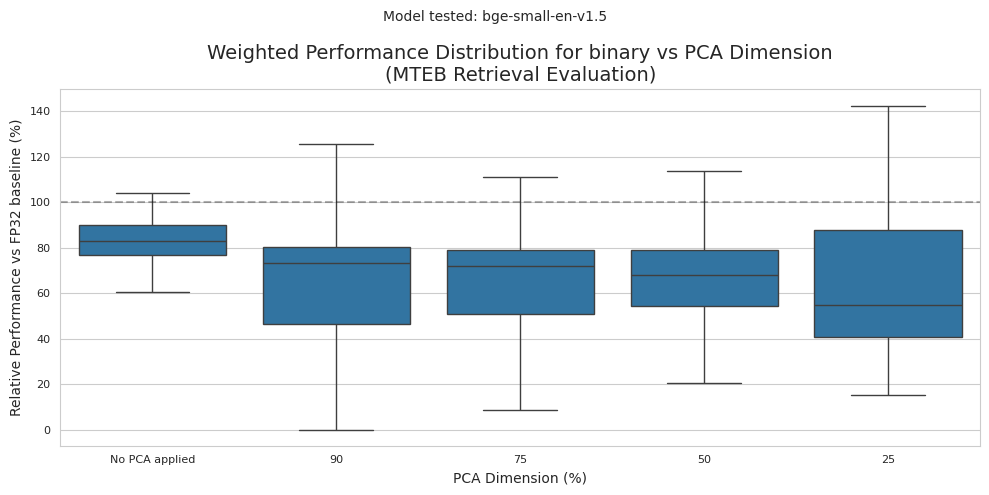

In [5]:
# Create separate boxplots for each data type and model
for model_path in models:
    # Load float32 baseline scores for this model
    with open(model_path / 'results_float32.json', 'r') as f:
        float32_data = json.load(f)
        float32_scores = float32_data['scores']

    # Group files by base data type
    dtype_groups = {
        'float32': [],
        'float16': [],
        'bfloat16': [],
        'float8_e5m2': [],
        'float8_e4m3': [],
        'float4': [],
        'int8': [],
        'binary': []
    }

    for result_file in model_path.glob('results_*.json'):
        dtype = result_file.stem.replace('results_', '')
        # Check exact match for float16 and bfloat16 to avoid mixing them up
        if dtype == 'float16' or dtype.startswith('float16_'):
            dtype_groups['float16'].append(result_file)
        elif dtype == 'bfloat16' or dtype.startswith('bfloat16_'):
            dtype_groups['bfloat16'].append(result_file)
        else:
            for base_type in ['float32', 'float8_e5m2', 'float8_e4m3', 'float4', 'int8', 'binary']:
                if base_type in dtype:
                    dtype_groups[base_type].append(result_file)

    for base_type, files in dtype_groups.items():
        if not files:
            continue
            
        pca_data = []
        high_performers = []
        
        for result_file in files:
            dtype = result_file.stem.replace('results_', '')
            
            # Extract PCA percentage, handling both PCA suffix and e5m2/e4m3 formats
            if '_' in dtype:
                pca_str = dtype.split('_')[-1]
                # Check if it's a PCA value
                if 'PCA' in pca_str:
                    pca_percent = int(pca_str.replace('PCA', ''))
                else:
                    # Skip non-PCA values (e.g., e5m2, e4m3)
                    continue
            else:
                pca_percent = 100
            
            with open(result_file, 'r') as f:
                data = json.load(f)
                
            # Calculate weighted relative performance for each benchmark score
            for task, score in data['scores'].items():
                baseline = float32_scores[task]
                relative_perf = (score / baseline) * 100
                weight = task_weights.get(task.split('-')[0], 0)  # Get base task name before -test
                
                # Track tasks performing >150% compared to baseline
                if relative_perf > 150:
                    high_performers.append((task, relative_perf, result_file.name))
                
                pca_data.append({
                    'pca_percent': pca_percent,
                    'relative_perf': relative_perf,
                    'weight': weight
                })
        
        if pca_data:
            # Print high performers for this data type
            if high_performers:
                print(f"\nHigh performers for {base_type} in {model_path.name} (>150% baseline):")
                for task, perf, file_name in high_performers:
                    print(f"{task}: {perf:.1f}% ({file_name})")
            
            # Create DataFrame
            df = pd.DataFrame(pca_data)
            
            # Create boxplot
            plt.figure(figsize=(10, 5))
            ax = plt.gca()
            
            # Filter for specific PCA percentages
            filtered_df = df[df['pca_percent'].isin([100, 90, 75, 50, 25])]
            
            # Replace 100 with "No PCA applied"
            filtered_df['pca_percent'] = filtered_df['pca_percent'].replace(100, 'No PCA applied')
            
            # Create a mapping for ordering
            order = ['No PCA applied', '90', '75', '50', '25']
            
            # Create weighted boxplot with ordered categories
            sns.boxplot(data=filtered_df, x='pca_percent', y='relative_perf', ax=ax, showfliers=False, order=order)  # Show full range without outliers
            
            plt.title(f'Weighted Performance Distribution for {base_type} vs PCA Dimension\n(MTEB Retrieval Evaluation)', fontsize=14)
            plt.suptitle(f'Model tested: {model_path.name}', fontsize=10)
            
            plt.xlabel('PCA Dimension (%)', fontsize=10)
            plt.ylabel('Relative Performance vs FP32 baseline (%)', fontsize=10)
            plt.axhline(y=100, color='black', linestyle='--', alpha=0.3)
            
            # Make tick labels readable
            plt.xticks(fontsize=8)
            plt.yticks(fontsize=8)
            
            plt.tight_layout()
            plt.show()
